In [1]:
import numpy as np
import matplotlib.pyplot as plt

import time 
#from tqdm import tqdm  # tqdm是显示循环进度条的库
from tqdm.notebook import tqdm #推荐在jupyter中使用自带的进度条
import copy #复制方法

#-------------------------------------------------------------------
np.random.seed(0) #重置种子为0
np.set_printoptions(precision=3, suppress=True, linewidth=100)#格式化输出
#-------------------------------------------------------------------

import rl_utils
import random
import gymnasium as gym
import collections
import torch
import torch.nn.functional as F
import os

## DPPG

基于策略梯度的算法 REINFORCE
Actor-Critic 以及两个改进算法——TRPO 和 PPO
都有一个共同特点—在线策略算法，意味着 **样本效率（sample efficiency）** 比较低。
<br>DQN 算法直接估计最优函数 Q，可以做到离线策略学习，但是它只能处理动作空间有限的环境，这是因为它需要从所有动作中挑选一个值最大的动作

#### 核心：动作空间无限 & 离线策略算法
**深度确定性策略梯度（deep deterministic policy gradient，DDPG）**算法就是用来处理动作空间无限的算法，它构造一个确定性策略，用梯度上升的方法来最大化Q值，DDPG也属于Actor-Critic算法，之前学习的是随机性策略并采样，而这次学习要给确定性策略


### DDPG算法公式
若随机策略，可以作为$a \sim \pi_{\theta}(\cdot \mid s)$，但是如果是确定性策略，就需要写成$a=\mu_\theta(s)$,因而而异导出**确定性策略梯度定理（deterministic policy gradient theorem）**:
$$
\nabla_{\theta} J\left(\pi_{\theta}\right)=\mathbb{E}_{s \sim \nu^{\pi_{\beta}}}\left[\left.\nabla_{\theta} \mu_{\theta}(s) \nabla_{a} Q_{\omega}^{\mu}(s, a)\right|_{a=\mu_{\theta}(s)}\right]
$$
这个公式是对$\mathbb{E}_{\pi_{\theta}}\left[Q^{\pi_{\theta}}(s, a) \nabla_{\theta} \log \pi_{\theta}(a \mid s)\right]$的调整

#### |目标网络--"软更新"
DDPG 要用到4个神经网络，其中 Actor 和 Critic 各用一个网络，此外它们都各自有一个目标网络。DDPG采用软更新的方式，不同于DQN:
$$
\omega^{-} \leftarrow \tau \omega+(1-\tau) \omega^{-}
$$
其中$\tau$是一个很小的参数，当$\tau=1$时，就和DQN更新一致了

#### |探索/利用--"OU随机噪声"
在 DDPG 的原始论文中，添加的噪声符合奥恩斯坦-乌伦贝克（Ornstein-Uhlenbeck，OU）随机过程：
$$
\Delta x_{t}=\theta\left(\mu-x_{t-1}\right)+\sigma W
$$
其中$\mu$是噪声的长期平均水平/均值，$\theta$控制噪声回归到平均值的速率，$\sigma$控制噪声的随机变量的波动程度，$W$是符合布朗运动的随机噪声<br>
OU过程较为复杂，不仅涉及当前随机扰动，还有前一个状态的噪声，因而具有一定"记忆性"：
```python
class OUNoise:
    def __init__(self, action_dimension, scale=0.1, mu=0, theta=0.15, sigma=0.2):
        self.action_dimension = action_dimension
        self.scale = scale
        self.mu = mu
        self.theta = theta
        self.sigma = sigma
        self.state = np.ones(self.action_dimension) * self.mu

    def reset(self):
        self.state = np.ones(self.action_dimension) * self.mu

    def noise(self):
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(len(x))
        self.state = x + dx
        return self.state * self.scale

# 使用OU噪声
ou_noise = OUNoise(action_dimension=self.action_dim)
# 在选择动作时添加OU噪声
action = action + ou_noise.noise()
```
注意增加了`scale`控制噪声的整体规模`

而在 DDPG 的实践中，不少地方仅使用正态分布的噪声，为了简单使用正态分布的噪声：
$$
A' = A + \sigma \cdot \epsilon
$$
其中$A'$是添加噪声后的动作，$A$ 是原始动作，$\sigma$ 是噪声的标准差（控制噪声的强度），$\epsilon$ 是服从标准正态分布<br>
正态分布的代码实现如下：
```python
action = action + self.sigma * np.random.randn(self.action_dim)
return action
```

### DDPG代码实现：
- 随机噪声可以用 $\mathcal{N}$ 来表示, 用随机的网络参数 $\omega$ 和 $\theta$ 分别初始化 Critic 网络 $Q_{\omega}(s, a)$ 和 Actor 网络 $\mu_{\theta}(s)$
- 复制相同的参数 $\omega^{-} \leftarrow \omega$ 和 $\theta^{-} \leftarrow \theta$，分别初始化目标网络 $Q_{\omega^{-}}$和 $\mu_{\theta^{-}}$
- 初始化经验回放池 $R$
- for 序列 $e=1 \rightarrow E$ do :
  - 初始化随机过程 $\mathcal{N}$ 用于动作探索
  - 获取环境初始状态 $s_{1}$
  - for 时间步 $t=1 \rightarrow T$ do :
    - 根据当前策略和噪声选择动作 $a_{t}=\mu_{\theta}\left(s_{t}\right)+\mathcal{N}$
    - 执行动作 $a_{t}$，获得奖励 $r_{t}$，环境状态变为 $s_{t+1}$
    - 将 $\left(s_{t}, a_{t}, r_{t}, s_{t+1}\right)$ 存储进回放池 $R$
    - 从 $R$ 中采样 $N$ 个元组 $\left\{\left(s_{i}, a_{i}, r_{i}, s_{i+1}\right)\right\}_{i=1, \ldots, N}$
      - 对每个元组，用目标网络计算 $y_{i}=r_{i}+\gamma Q_{\omega^{-}}\left(s_{i+1}, \mu_{\theta^{-}}\left(s_{i+1}\right)\right)$
    - 最小化目标损失 $L=\frac{1}{N} \sum_{i=1}^{N}\left(y_{i}-Q_{\omega}\left(s_{i}, a_{i}\right)\right)^{2}$, 以此更新当前 Critic 网络
    - 计算采样的策略梯度, 以此更新当前 Actor 网络:
      $$\left.\nabla_{\theta} J \approx \frac{1}{N} \sum_{i=1}^{N} \nabla_{\theta} \mu_{\theta}\left(s_{i}\right) \nabla_{a} Q_{\omega}\left(s_{i}, a\right)\right|_{a=\mu_{\theta}\left(s_{i}\right)}$$
    - 更新目标网络:<br>
      $\omega^{-} \leftarrow \tau \omega+(1-\tau) \omega^{-}$<br>
      $\theta^{-} \leftarrow \tau \theta+(1-\tau) \theta^{-}$
    - end for
- end for

## DDPG代码实现
### ✅DDPG注意点

- DDPG引入软更新概念，即对于目标网络的更新，不再是延迟更新，而是每次只更新一点点; 

- 并且把评论员网络变成Q网络，同时输入状态和动作，将它们拼接起来送入网络，之前DQN中没有这样做过，换成Q网络之后，输出一个价值，也就是这个动作状态的价值，但是只有确定性策略，动作是确定的，才能这样设计网络;

- 策略/演员网络直接输出动作，也就是确定性深度策略梯度中`确定性`的来源，之前是输出一个概率，现在是直接确定动作;

### PolicyNet & QValueNet
- forward函数使用`tanh`的正切函数作为激活函数，因为值域为[-1,1]，方便按照`action_bound`「环境可接受动作最大值」比例调整
- 在Dueling DQN中，V(s)和A(s,a)前几层共享一套参数，输入s输出Q，但不是最优
- 在QValueNet中，直接输入s,a输出Q(s,a)

In [2]:
class PolicyNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim, action_bound):
        super().__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)
        self.action_bound = action_bound  # action_bound是环境可以接受的动作最大值

    def forward(self, x):
        x = F.relu(self.fc1(x))
        # 这里直接缩放并输出, 而非像PPO中输出均值方差再采样
        return torch.tanh(self.fc2(x)) * self.action_bound  # 缩放到动作空间


class QValueNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super().__init__()
        self.fc1 = torch.nn.Linear(state_dim + action_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc_out = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x, a):
        # * 拼接状态和动作, 似乎是DDPG首次采用, 之前的Q网络只输入状态, 输出动作状态
        cat = torch.cat([x, a], dim=1)
        x = F.relu(self.fc1(cat))
        x = F.relu(self.fc2(x))
        return self.fc_out(x)

In [3]:
class DDPG:
    ''' DDPG算法 '''
    def __init__(self, state_dim, hidden_dim, action_dim, action_bound,
                 sigma, actor_lr, critic_lr, tau, gamma, device, training=True):
        self.training = training
        self.actor = PolicyNet(state_dim, hidden_dim, action_dim, action_bound).to(device)
        self.critic = QValueNet(state_dim, hidden_dim, action_dim).to(device)
        self.target_actor = PolicyNet(state_dim, hidden_dim, action_dim, action_bound).to(device)
        self.target_critic = QValueNet(state_dim, hidden_dim, action_dim).to(device)
        # 初始化目标价值网络并设置和价值网络相同的参数
        self.target_critic.load_state_dict(self.critic.state_dict())
        # 初始化目标策略网络并设置和策略相同的参数
        self.target_actor.load_state_dict(self.actor.state_dict())
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=critic_lr)
        self.gamma = gamma
        self.sigma = sigma  # 高斯噪声的标准差, 均值直接设为0
        self.tau = tau  # 目标网络软更新参数
        self.action_dim = action_dim
        self.device = device

    def take_action(self, state):
        state = torch.tensor(state[np.newaxis, :], dtype=torch.float).to(self.device)
        action = self.actor(state).item()  # * 在这里和网络分离了, 因此后面不需要.item()
        if self.training:
            # 给动作添加噪声，增加探索, 但是验证和测试时不需要
            action = action + self.sigma * np.random.randn(self.action_dim)
        return action

    def soft_update(self, net, target_net):
        '''将target_net往net方向软更新, 每次更新幅度都很小

        参数说明
        ----------
        net : torch.nn.module
        target_net : torch.nn.module
        '''
        for param_target, param in zip(target_net.parameters(), net.parameters()):
            param_target.data.copy_(param_target.data * (1.0 - self.tau) + param.data * self.tau)

    def update(self, transition_dict):
        states = torch.tensor(
            transition_dict['states'], dtype=torch.float).to(self.device)
        actions = torch.tensor(
            transition_dict['actions'], dtype=torch.float).view(-1, 1).to(self.device)
        rewards = torch.tensor(
            transition_dict['rewards'], dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(
            transition_dict['next_states'], dtype=torch.float).to(self.device)
        dones = torch.tensor(
            transition_dict['dones'], dtype=torch.int).view(-1, 1).to(self.device)
        truncated = torch.tensor(
            transition_dict['truncated'], dtype=torch.int).view(-1, 1).to(self.device)

        # 评论员还是时序差分更新, 评论员现在叫Q网络, 但是和之前价值网络一样
        # 不同点是需要输入状态和动作, 动作由演员选择, DQN里面的Q网络不需要输入动作
        # 这也是和DQN的主要区别和改进之处
        next_q_values = self.target_critic(next_states, self.target_actor(next_states))
        q_targets = rewards + self.gamma * next_q_values * (1 - dones | truncated)
        critic_loss = torch.mean(F.mse_loss(self.critic(states, actions), q_targets))
        # 评论员梯度下降
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()
        # * 注意: 演员是梯度策略, 采用梯度上升, 加负号
        actor_loss = -torch.mean(self.critic(states, self.actor(states)))
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()
        # 一直更新, 但是缓慢更新
        self.soft_update(self.actor, self.target_actor)  # 软更新策略网络
        self.soft_update(self.critic, self.target_critic)  # 软更新价值网络



In [4]:

# DDPG算法相关
PATH = 'checkpoints/DDPG_PDv2.pt'
actor_lr = 3e-4
critic_lr = 3e-3
total_episodes = 50
total_epochs = 20
gamma = 0.98
tau = 0.005  # 软更新参数, tau越小更新幅度越小
buffer_size = 10000
minimal_size = 1000
batch_size = 64
sigma = 0.01  # 高斯噪声标准差
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)
replay_buffer = rl_utils.ReplayBuffer(buffer_size)

# 环境相关
env_name = 'Pendulum-v1'
env = gym.make(env_name)
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

# 神经网络相关
state_dim = env.observation_space.shape[0]
hidden_dim = 64
action_dim = env.action_space.shape[0]
action_bound = env.action_space.high[0]  # 动作最大值

agent = DDPG(state_dim, hidden_dim, action_dim, action_bound,
             sigma, actor_lr, critic_lr, tau, gamma, device)

# 其他
policy_name = agent.__class__.__name__  # 算法(类)名称

cuda


In [5]:
def read_ckp(agent,CKP_PATH):
    if os.path.exists(CKP_PATH):
        tmp = torch.load(CKP_PATH)
        agent.gamma = tmp.get("gamma",None)
        agent.tau = tmp.get("tau",None)
        agent.sigma = tmp.get("sigma",None)
        agent.actor.load_state_dict(tmp.get("actor_weight",None))
        agent.critic.load_state_dict(tmp.get("critic_weight",None))
        agent.target_actor.load_state_dict(tmp.get("target_actor_weight",None))
        agent.target_critic.load_state_dict(tmp.get("target_critic_weight",None))
        return tmp.get("epoch",0),tmp.get("episode",0),tmp.get("return_list",[])
    else:
        os.makedirs(os.path.dirname(CKP_PATH), exist_ok=True)
        return 0,0,[]

def save_ckp(data, PATH):
    os.makedirs(os.path.dirname(PATH), exist_ok=True)  # 确保路径存在
    torch.save(data, PATH)

CKP_PATH = 'checkpoints/12_v2_DDPG.pt'
BEST_CKP_PATH = 'checkpoints/12_v2_best_PPDG.pt'
PATH = 'checkpoints/12_v5_rlu_DDPG.pt'
#s_epoch,s_episode,return_list = read_ckp(agent,CKP_PATH)
s_epoch,s_episode,return_list = 0,0,[]

<1/20>:   0%|          | 0/50 [00:00<?, ?it/s]

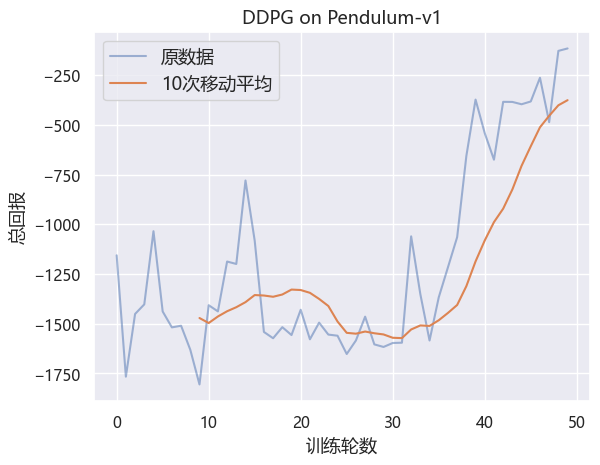

<2/20>:   0%|          | 0/50 [00:00<?, ?it/s]

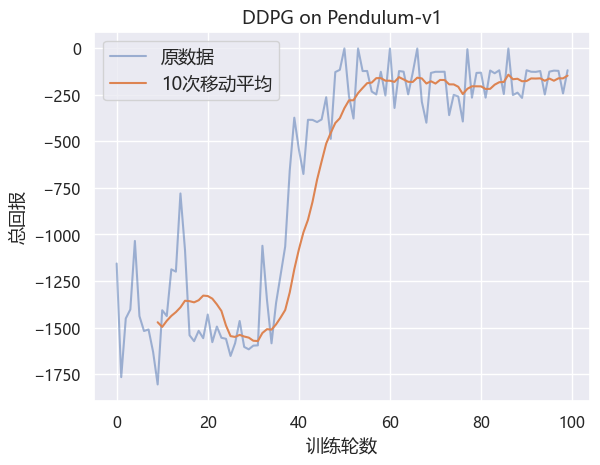

<3/20>:   0%|          | 0/50 [00:00<?, ?it/s]

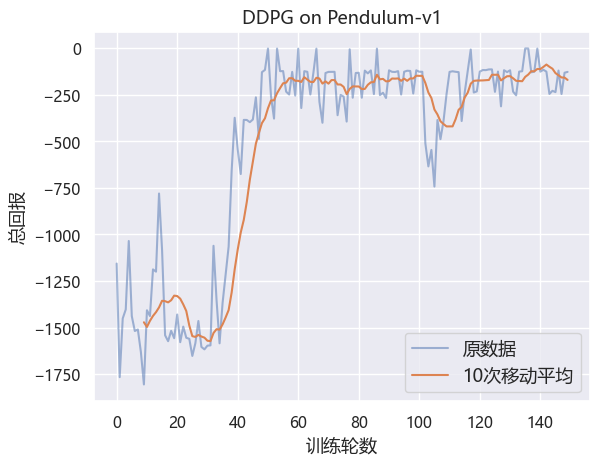

<4/20>:   0%|          | 0/50 [00:00<?, ?it/s]

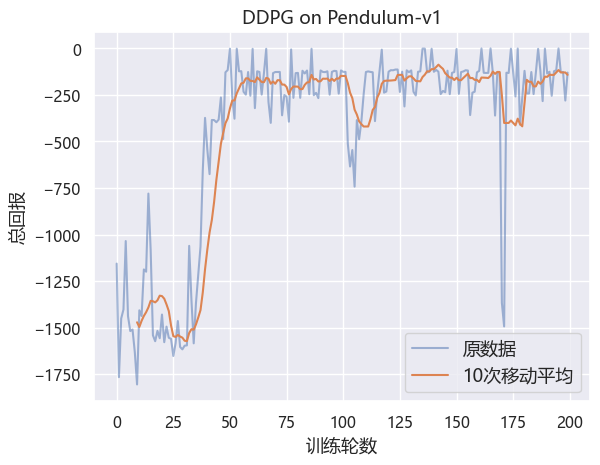

<5/20>:   0%|          | 0/50 [00:00<?, ?it/s]

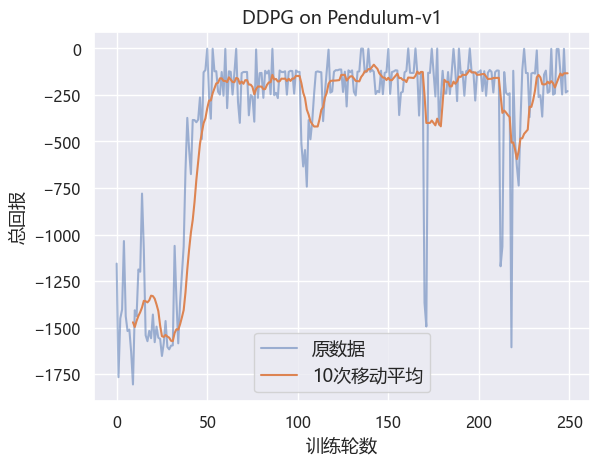

<6/20>:   0%|          | 0/50 [00:00<?, ?it/s]

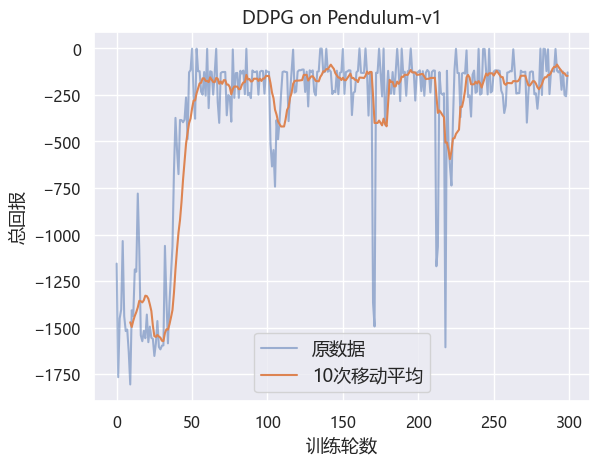

<7/20>:   0%|          | 0/50 [00:00<?, ?it/s]

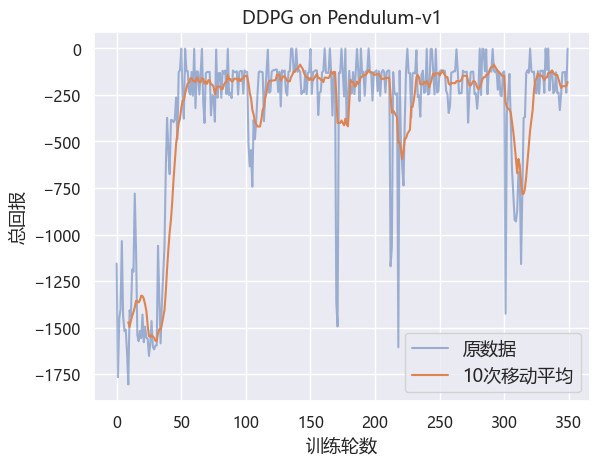

<8/20>:   0%|          | 0/50 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [6]:
rl_utils.train_off_policy_agent(env, agent, s_epoch, total_epochs, s_episode, total_episodes, replay_buffer, minimal_size, batch_size, return_list, PATH, 2)

In [ ]:
rl_utils.picture_return(return_list, 'DDPG', 'Pendulum-v1', 10)

## 附录：
### DDPG推导过程
#### 策略梯度算法
目标策略$a \sim \pi_{\theta}(\cdot \mid s)$是一个随机性策略，目标函数为：
$$
J(\theta)=\mathbb{E}_{s_{0}}\left[V^{\pi_{\theta}}\left(s_{0}\right)\right]
$$
其中$s_0$为初始状态，将目标函数J对$\theta$求导，就可以用梯度上升来最大化目标函数
#### DDPG期望回报定义：
目标策略$a=\mu_\theta(s)$是一个确定性策略，目标函数为：
$$
J(\theta) = \mathbb{E}_{s \sim \nu^{\pi_{\beta}}}[Q_{\omega}^{\mu}(s, \mu_{\theta}(s))]
$$
根据梯度的链式法则，就能求出上述的DDPG公式了